# Introduction

The following notebook involves a dataset on guest reviews for a number of different hotels. The data is a mixture of numerical and categorical data. The ultimate goal is to analyse the text data for both positive and negative reviews and see if the review data, coupled with the other numeric data, can be used to successfully predict the overall score for the hotel (for simplicity, this overall score is converted to either a positive or negative score - 0 or 1).

# Package Imports

In [199]:
#Importing the packages we will be using
# Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# SK Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC, LinearSVC

## Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK
import nltk

In [200]:
# NLTK Packages
# Use the code below to download the NLTK package, a straightforward GUI should pop up
# nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Utility functions

##### EDA

In [201]:
#Overall Summary:
def basic_eda(df,df_name):
    """
    Summary: This function summarises key metrics regarding a dataset, to be used in the data checking phase, 
    including the % of null and duplicate rows. 
    
    Inputs: df = dataframe to check.
            df_name = name of the dataframe to check.
            
    Outputs: - Number of Rows/Columns.
             - Percentage of null rows
             - Percentage of duplicate rows
             - Data types
    
    """
    print(df_name.upper())
    print()
    print(f'Rows: {df.shape[0]} \t Columnss: {df.shape[1]}')
    
    print(f'Total null rows: {df.isnull().sum().sum()}')
    print(f'Percentage null rows: {round(df.isnull().sum().sum()/df.shape[0]* 100,2)}%')
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0]/df.shape[0]*100,2)}%")
    print()
    
    print(df.dtypes)
    print("----\n")

#### Text cleaning

In [202]:
def remove_numbers(document):
    extract = r'[0-9]'
    document= re.sub(r"[a-zA-Z]+(\d+)|(\d+)[a-zA-Z]|[0-9]", "", document) 
    return document


In [203]:
def remove_whitespace_tokens(document):
    '''
    Removes whitespace/empty tokens from document (string)
    '''
    document = [word for word in document if word!= '']
    return document

In [204]:
def remove_punctuation(document, punc):
    '''
    Removes punctuation provided (string) from document (string)
    '''
    document = re.sub(f"\{punc}", '', document)
    
    return document

In [205]:
def remove_all_punctuation(document):
    '''
    Removes all punctuation (found in string.punctuation) from document (string)
    '''
    
    for punc in string.punctuation:
        document = remove_punctuation(document, punc)
    
    return document

In [206]:
def remove_stopwords(list_of_tokens):
    """
    Literally removes stopwords
    """
    
    stop_words = stopwords.words('english')
    
    cleaned_tokens = [] 
    
    for token in list_of_tokens: 
        if token not in stop_words: 
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [207]:
def stemmer(list_of_tokens):
    '''
    Takes in an input which is a list of tokens, and spits out a list of stemmed tokens.
    '''
    
    stemmed_tokens_list = []
    
    for i in list_of_tokens:
        token = PorterStemmer().stem(i)
        stemmed_tokens_list.append(token)
        
    return stemmed_tokens_list

In [208]:
def lemmatizer(list_of_tokens):
    
    lemmatized_tokens_list = []
    
    for i in list_of_tokens: 
        token = WordNetLemmatizer().lemmatize(i)
        lemmatized_tokens_list.append(token)
        
    return lemmatized_tokens_list

In [209]:
def my_tokenizer(document, lemmatization=False, stemming=True):
    '''
    Function for use in Vectorizer that tokenizes the document and performs the following operations:
    1. remove numbers from the original string
    2. lowercase all letters in the string
    3. remove all punctuation in the string
    4. tokenize
    5. remove stopwords
    6. lemmatize/stem (if applicable)
    '''
    #remove numbers
    document = remove_numbers(document)
    # lowercase
    document = str.lower(document)
    # remove punctuation
    document = remove_all_punctuation(document)
    # tokenize - split on whitespace
    tokenized_document = document.split(' ')
    # remove stopwords
    tokenized_document = remove_stopwords(tokenized_document)
    # lemmatization
    if lemmatization:
        tokenized_document = lemmatizer(tokenized_document)
        tokenized_document = remove_whitespace_tokens(tokenized_document)
    # stemming
    if stemming:
        tokenized_document = stemmer(tokenized_document)
        tokenized_document = remove_whitespace_tokens(tokenized_document)

    return tokenized_document

#### Visualisation

In [210]:
def plot_most_frequent(words, word_counts, top=20):
    '''
    Takes in a list of words, the word count, and plots a bar chart of the 20 most common words
    '''
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()

# Data Import

In [211]:
df = pd.read_csv('./data/Hotel_Reviews.csv')

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [213]:
df.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.395077,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.637856,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [214]:
basic_eda(df,'df_raw')

DF_RAW

Rows: 515738 	 Columnss: 17
Total null rows: 6536
Percentage null rows: 1.27%

Total duplicate rows: 1052
Percentage dupe rows: 0.2%

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           fl

1.2% of rows are Null, and 0.2% of rows are duplicates. Let's fix this.

In [215]:
# investigating the duplicate rows
df[df.duplicated(keep=False)]

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
23703,100 110 Euston Road Camden London NW1 2AJ Unit...,728,2/25/2017,8.9,Pullman London St Pancras,China,none,2,3168,good location and super nice staff room is bi...,13,39,9.6,"[' Business trip ', ' Solo traveler ', ' Class...",159 day,51.528677,-0.128349
23704,100 110 Euston Road Camden London NW1 2AJ Unit...,728,2/25/2017,8.9,Pullman London St Pancras,China,none,2,3168,good location and super nice staff room is bi...,13,39,9.6,"[' Business trip ', ' Solo traveler ', ' Class...",159 day,51.528677,-0.128349
61875,16 22 Great Russell Street Camden London WC1B ...,300,7/27/2017,9.0,The Bloomsbury Hotel,Israel,No Negative,0,1254,The attention received by Sebastian and his t...,12,4,9.6,"[' Leisure trip ', ' Couple ', ' Superior Doub...",7 days,51.517167,-0.129053
61876,16 22 Great Russell Street Camden London WC1B ...,300,7/27/2017,9.0,The Bloomsbury Hotel,Israel,No Negative,0,1254,The attention received by Sebastian and his t...,12,4,9.6,"[' Leisure trip ', ' Couple ', ' Superior Doub...",7 days,51.517167,-0.129053
68936,167 rue de Rome 17th arr 75017 Paris France,11,6/23/2017,6.8,Villa Eugenie,Netherlands,Location is very old not invested in past yea...,41,165,Location is central accessible by train parki...,12,24,4.6,"[' Business trip ', ' Solo traveler ', ' Singl...",41 days,48.887128,2.314205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470439,Via Albricci 2 4 Milan City Center 20122 Milan...,493,3/8/2017,9.0,The Square Milano Duomo,Monaco,No Negative,0,4192,Excellent,2,33,10.0,"[' Business trip ', ' Solo traveler ', ' Delux...",148 day,45.460860,9.189022
489214,Via Senigallia 6 20161 Milan Italy,904,1/4/2016,8.1,Hotel Da Vinci,Greece,The location is too far from city center 1 km...,29,16670,Excellent breakfast variaty of goods wifi goo...,16,11,6.7,"[' Leisure trip ', ' Family with older childre...",577 day,45.533137,9.171102
489215,Via Senigallia 6 20161 Milan Italy,904,1/4/2016,8.1,Hotel Da Vinci,Greece,The location is too far from city center 1 km...,29,16670,Excellent breakfast variaty of goods wifi goo...,16,11,6.7,"[' Leisure trip ', ' Family with older childre...",577 day,45.533137,9.171102
492717,Via Tortona 35 Navigli 20144 Milan Italy,162,9/11/2015,8.6,Nhow Milan,United States of America,No Negative,0,2286,The hotel is a beautiful gallery boutique hot...,108,18,10.0,"[' Leisure trip ', ' Couple ', ' Standard Doub...",692 day,45.451042,9.160654


From the above, the duplicate rows seem to be an error. The reviews are worded identically, which is incredibly unlikely from two unique reviewers. Hence, the duplicate rows should  be dropped.

In [216]:
df = df.drop_duplicates()

In [217]:
# investigating the null rows
df[df.isnull().any(axis=1)]

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
99488,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,Australia,No Negative,0,377,Upgraded rooms are excellent Good size for tr...,25,6,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99489,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Noise Not being told about this when we check...,12,377,The location was great However renovations we...,45,1,6.7,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99490,20 Rue De La Ga t 14th arr 75014 Paris France,22,7/25/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,Room was worn down One of the curtains did no...,43,377,Location was good,5,1,5.4,"[' Leisure trip ', ' Solo traveler ', ' Standa...",9 days,NaN,NaN
99491,20 Rue De La Ga t 14th arr 75014 Paris France,22,6/22/2017,7.8,Mercure Paris Gare Montparnasse,Australia,Access to shower was by the tub which is very...,54,377,No Positive,0,13,8.3,"[' Leisure trip ', ' Couple ', ' Standard Twin...",42 days,NaN,NaN
99492,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/24/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,The breakfast was way over priced and the sta...,83,377,The property was conveniently located near th...,11,2,5.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",71 days,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500563,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,8/16/2015,7.8,Hotel Atlanta,Italy,soundy floor poor Wi Fi,7,2724,Good value for money good position for moving...,15,31,7.9,"[' Leisure trip ', ' Family with young childre...",718 day,NaN,NaN
500564,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,8/13/2015,7.8,Hotel Atlanta,Canada,No air conditioner Bad experience in summer,9,2724,No Positive,0,2,5.4,"[' Family with young children ', ' Quintuple R...",721 day,NaN,NaN
500565,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,8/12/2015,7.8,Hotel Atlanta,Pakistan,nothing,2,2724,nothing,2,1,10.0,"[' Leisure trip ', ' Solo traveler ', ' Single...",722 day,NaN,NaN
500566,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,8/11/2015,7.8,Hotel Atlanta,Romania,It was very very very hot At 5Th floor with n...,21,2724,No Positive,0,17,5.0,"[' Leisure trip ', ' Group ', ' Double or Twin...",723 day,NaN,NaN


The columns `lat` and `lon` seem to be the only rows with missing values. The below dictionary contains the missing latitude and longitudes.

In [218]:
address_dict_lat = {
    "Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria":48.20973212229249,
    "Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria":48.21365886827874,
    "W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria":48.22037640343485,
    "4 rue de la P pini re 8th arr 75008 Paris France":48.87543018081876,
    "Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria": 48.18900287980774,
    "W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria":48.216889210738536,
    "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria":48.219719743489506,
    "Sieveringer Stra e 4 19 D bling 1190 Vienna Austria":48.24598486036778,
    "Bail n 4 6 Eixample 08010 Barcelona Spain":41.3916067055017,
    "Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria":48.22140785313142,
    "Hasenauerstra e 12 19 D bling 1190 Vienna Austria":48.233657516332094,
    "Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria":48.209733072984946,
    "23 Rue Damr mont 18th arr 75018 Paris France":48.88904674060277,
    "Paragonstra e 1 11 Simmering 1110 Vienna Austria":48.18702518830341,
    "20 Rue De La Ga t 14th arr 75014 Paris France":48.840574726064574,
    "Pau Clar s 122 Eixample 08009 Barcelona Spain":41.39324830826093,
    "Sep lveda 180 Eixample 08011 Barcelona Spain":41.383962986407724
}
address_dict_lng = {
    "Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria":16.35332195361707,
    "Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria":16.380089669003404,
    "W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria":16.35584118434589,
    "4 rue de la P pini re 8th arr 75008 Paris France":2.32366021875095,
    "Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria":16.38390471318031,
    "W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria":16.36015155551013,
    "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria":16.285938135919036,
    "Sieveringer Stra e 4 19 D bling 1190 Vienna Austria":16.341917840169025,
    "Bail n 4 6 Eixample 08010 Barcelona Spain":2.1787467393939446,
    "Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria":16.362174284345883,
    "Hasenauerstra e 12 19 D bling 1190 Vienna Austria":16.346190196037444,
    "Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria":16.35137368465779,
    "23 Rue Damr mont 18th arr 75018 Paris France":2.3336357957279206,
    "Paragonstra e 1 11 Simmering 1110 Vienna Austria":16.42234748300391,
    "20 Rue De La Ga t 14th arr 75014 Paris France":2.3264800432701636,
    "Pau Clar s 122 Eixample 08009 Barcelona Spain":2.1674405153422085,
    "Sep lveda 180 Eixample 08011 Barcelona Spain":2.16445163697729
}

In [219]:
# iterate through the rows and replace any missing latitude/longitude values with corresponding vals in the above dictionary.
for index, row in df.iterrows():
    if row[0] in address_dict_lat.keys():
        df.loc[index,'lat'] = address_dict_lat[row[0]]
        df.loc[index,'lng'] = address_dict_lng[row[0]]

In [220]:
df.isnull().sum(axis=0)

Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                          0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

There are now no more missing values. 

# EDA

In [221]:
df.shape
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 515212
Number of columns: 17


In [222]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [223]:
df.iloc[12,:]

Hotel_Address                                  s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
Additional_Number_of_Scoring                                                                194
Review_Date                                                                            7/6/2017
Average_Score                                                                               7.7
Hotel_Name                                                                          Hotel Arena
Reviewer_Nationality                                                            United Kingdom 
Negative_Review                                The floor in my room was filfy dirty Very bas...
Review_Total_Negative_Word_Counts                                                            28
Total_Number_of_Reviews                                                                    1403
Positive_Review                                                        Comfy bed good location 
Review_Total_Positive_Word_Counts       

Taking the index 12 as an example, the `Reviewer_Score` is 4.6. Let's round this to 5.

In [224]:
df.loc[:,'Reviewer_Score'] = round(df.loc[:,'Reviewer_Score'],0)

In [225]:
# checking the change has been implemented correctly...
df.iloc[12,:]

Hotel_Address                                  s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
Additional_Number_of_Scoring                                                                194
Review_Date                                                                            7/6/2017
Average_Score                                                                               7.7
Hotel_Name                                                                          Hotel Arena
Reviewer_Nationality                                                            United Kingdom 
Negative_Review                                The floor in my room was filfy dirty Very bas...
Review_Total_Negative_Word_Counts                                                            28
Total_Number_of_Reviews                                                                    1403
Positive_Review                                                        Comfy bed good location 
Review_Total_Positive_Word_Counts       

We can see the reviewer score is now 5, meaning the column has been succesfully rounded to a whole number.

An appropriate guess for the distribution of scores would be that they are normally distributed. Let's see how they are actually distributed...

In [226]:
df['Reviewer_Score'].describe()

count    515212.000000
mean          8.458019
std           1.683300
min           2.000000
25%           8.000000
50%           9.000000
75%          10.000000
max          10.000000
Name: Reviewer_Score, dtype: float64

Text(0.5, 0, 'Reviewer Score')

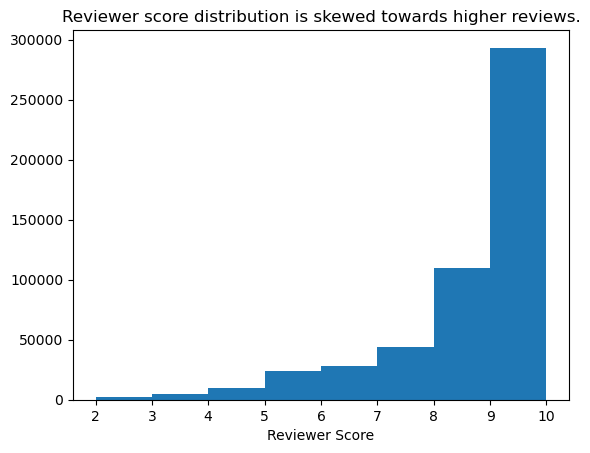

In [227]:
plt.hist(data=df, x='Reviewer_Score', bins=8)
plt.title('Reviewer score distribution is skewed towards higher reviews.')
plt.xlabel('Reviewer Score')

There appears to be no review less than 2. The review scores are skewed to the right, with a long left tail. This distribution is suggestive of an exponential distribution. 

This can be problematic in classification problems because it means that class imbalance will pose issues in determining suitable boundaries. The fact that there are significantly more data points for the higher review ratings means that the model may be more succeptible to overfitting. The model is more likely to form class boundaries which favour the higher ratings, and so may generalise poorly when exposed to a dataset containing an unusually large proportion of lower ratings.

In [228]:
# obtain a list of all columns with numeric data
df.select_dtypes(np.number).columns.tolist()

['Additional_Number_of_Scoring',
 'Average_Score',
 'Review_Total_Negative_Word_Counts',
 'Total_Number_of_Reviews',
 'Review_Total_Positive_Word_Counts',
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'Reviewer_Score',
 'lat',
 'lng']

The numeric data is found in the following columns :

 'Additional_Number_of_Scoring'

 'Average_Score'

 'Review_Total_Negative_Word_Counts'

 'Total_Number_of_Reviews'

 'Review_Total_Positive_Word_Counts'

 'Total_Number_of_Reviews_Reviewer_Has_Given'

 'Reviewer_Score'

 'lat'

 'lng'
 

In [229]:
#obtain all non-numeric data
df.select_dtypes('object','datetime').columns.tolist()

['Hotel_Address',
 'Review_Date',
 'Hotel_Name',
 'Reviewer_Nationality',
 'Negative_Review',
 'Positive_Review',
 'Tags',
 'days_since_review']

The non-numeric data is found in the following columns:

 'Hotel_Address'

 'Review_Date'

 'Hotel_Name'

 'Reviewer_Nationality'

 'Negative_Review'

 'Positive_Review'

 'Tags'
 
 'days_since_review'

In [230]:
df.select_dtypes('object','datetime').head()

,Hotel_Address,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review,Tags,days_since_review
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/3/2017,Hotel Arena,Russia,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/3/2017,Hotel Arena,Ireland,No Negative,No real complaints the hotel was great great ...,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/31/2017,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,"[' Leisure trip ', ' Family with young childre...",3 days
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/31/2017,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/24/2017,Hotel Arena,New Zealand,You When I booked with your company on line y...,Amazing location and building Romantic setting,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days


As can be seen from the above, the `days_since_review` is actually storing numeric information. The 'days' can be dropped, leaving just the numeric representation.

In [231]:
#dropping 'days' from the column
df['days_since_review'] = df['days_since_review'].str.replace('days','')
df['days_since_review'] = df['days_since_review'].str.replace('day','')

In [232]:
df['days_since_review'].sample(10)

362390    213 
264701    450 
296143    487 
386450    385 
175424    438 
216957    519 
459733    241 
462801    281 
296341    729 
443052    231 
Name: days_since_review, dtype: object

In [233]:
df['days_since_review'] = df['days_since_review'].astype('int')

In [234]:
df['days_since_review'].dtype

dtype('int64')

The `days_since_review` has been succesfully changed to an integer column. 

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515212 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515212 non-null  object 
 1   Additional_Number_of_Scoring                515212 non-null  int64  
 2   Review_Date                                 515212 non-null  object 
 3   Average_Score                               515212 non-null  float64
 4   Hotel_Name                                  515212 non-null  object 
 5   Reviewer_Nationality                        515212 non-null  object 
 6   Negative_Review                             515212 non-null  object 
 7   Review_Total_Negative_Word_Counts           515212 non-null  int64  
 8   Total_Number_of_Reviews                     515212 non-null  int64  
 9   Positive_Review                             515212 non-null  object 
 

In [236]:
df.nunique()

Hotel_Address                                   1493
Additional_Number_of_Scoring                     480
Review_Date                                      731
Average_Score                                     34
Hotel_Name                                      1492
Reviewer_Nationality                             227
Negative_Review                               330011
Review_Total_Negative_Word_Counts                402
Total_Number_of_Reviews                         1142
Positive_Review                               412601
Review_Total_Positive_Word_Counts                365
Total_Number_of_Reviews_Reviewer_Has_Given       198
Reviewer_Score                                     9
Tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
dtype: int64

There are some non-numeric categories that could be converted into numeric via a one hot encoding process (Hotel_Name, Tags, Reviewer Nationality, and the country could be extracted from Hotel_Address). This would add 1000s of more features, as for Hotel_Name alone there are 1492 unique names in the dataset. For the time being, it is decided to ignore this step, as there is the risk of adding unnecessary noise to the problem. As we are only interested in sentiment, it is assumed that the majority of signals will come from the Positive_Review and Negative_Review. If the classification model performs poorly, then the second iteration could turn these categorical features into numeric features.

### Data Wrangling

Going forward, 10% of the original dataset is to be sampled to help with run time speeds.

In [237]:
import math
sample_size = math.ceil(0.1*df.shape[0])
df_sample = df.sample(n=sample_size)

In [238]:
df_sample.shape

(51522, 17)

The sample data has been successfully coverted to `sample_df`, with 51522 rows and 17 columns.

The review scores are converted to binary, where scores of 9 and above are given a 1 (good), and below 9 given a 0 (bad).

In [239]:
df_sample['Reviewer_Score'] = np.where(df_sample['Reviewer_Score']>=9,1,0)

<AxesSubplot:>

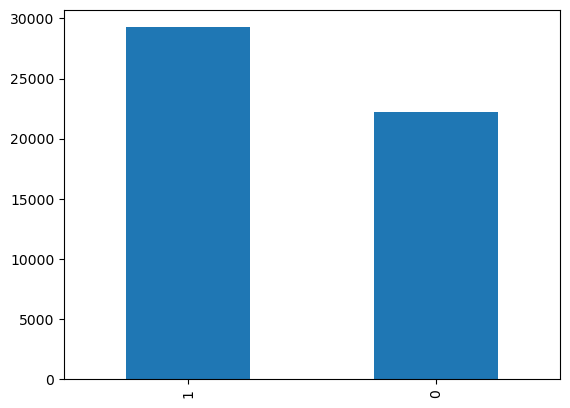

In [240]:
df_sample['Reviewer_Score'].value_counts().plot(kind='bar')

There appears to be a relatively even split between good and bad reviews (29238 good, 22284 bad), which means that there is a decent amount of variance in the target variable, which ultimately is good news for a classification problem.

Let's drop all non-numeric columns (except `Positve_Review` and `Negative_Review`) from the dataset.

In [241]:
df_sample = pd.concat([(df_sample.select_dtypes(np.number)),(df_sample[['Positive_Review', 'Negative_Review']])], axis = 1)

In [242]:
df_sample.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,days_since_review,lat,lng,Positive_Review,Negative_Review
409684,347,8.4,0,3510,2,4,0,59,45.484514,9.205753,Convenience,No Negative
1207,639,9.2,12,2619,21,1,1,478,51.513734,-0.108751,upgraded when we arrived to a lovely spacious...,bed could be a little softer possibly with a ...
412159,488,8.2,162,4645,4,1,0,490,41.411165,2.219201,Nothing to share,Booking com is more crap then the hotel I was...
104105,122,7.8,3,612,17,1,1,303,51.520544,-0.130809,Great location great staff Will definitely be...,Nothing
34916,421,8.5,32,1802,37,8,1,621,51.495923,-0.170292,The rooms were clean and well presented and h...,The staff at breakfast could be a little more...


### split data into train and test

In [243]:
y = df_sample['Reviewer_Score']

X = df_sample.drop(columns = 'Reviewer_Score')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=20, stratify=y)
 #The parameter stratify y means that the proportion of positive and negative reviews in the original data transfers to the train/test split.

In [244]:
X.columns

Index(['Additional_Number_of_Scoring', 'Average_Score',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'days_since_review',
       'lat', 'lng', 'Positive_Review', 'Negative_Review'],
      dtype='object')

In [245]:
X_test.shape

(15457, 11)

In [246]:
X_train.shape

(36065, 11)

### Vectorize text

#### Cleaning the text data

The bag of words model needs to be instantiated. For the moment, only TF model is used. If the results of the TF are sub-par, then the next iteration can make use of the TFIDF model.

In [247]:
# Instantiate TF model. Note that tokens are being stemmed but NOT lemmatized at this stage. The my_tokeniser is defined in the Utility Function section at the top.
# instantiate a positive bagofwords model
bagofwords_posi_tf = CountVectorizer(tokenizer=my_tokenizer, min_df=10, max_df=0.8)

The `Positive_Reviews` column and the `Negative_Reviews` column need to be isolated and treated separately, to create two separare vectorization matrices. Vectorizing the positive reviews first...

In [248]:
X_train_posi = X_train['Positive_Review']
X_test_posi = X_test['Positive_Review']

In [249]:
#fit the positive bagofwords with training data
bagofwords_posi_tf.fit(X_train_posi)
# transform both the training and test data
X_train_posi_transform = bagofwords_posi_tf.transform(X_train_posi)
X_test_posi_transform = bagofwords_posi_tf.transform(X_test_posi)

/Users/henryparemain/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [250]:
X_train_posi_transform.shape

(36065, 1791)

As can be seen, the word vectorisation matrix is 36065 rows long(the number of reviews in our training sample), and 1812 columns wide (the number of unique tokens from the positive reviews). Let's visualise the tokens to see the most frequent positive tokens.

/Users/henryparemain/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


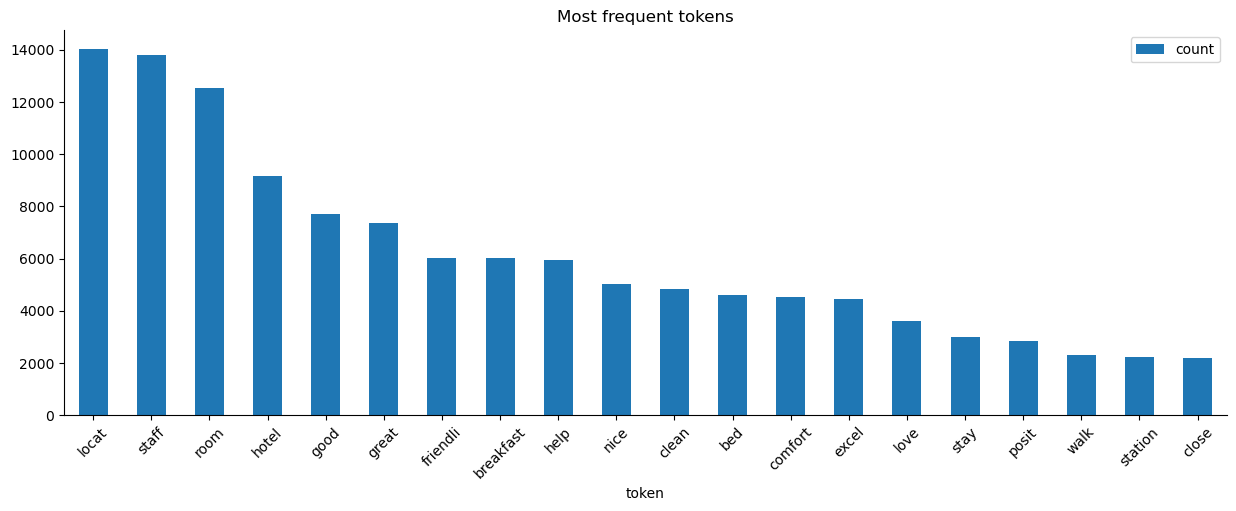

In [251]:
words = bagofwords_posi_tf.get_feature_names()
word_counts = X_train_posi_transform.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

This seems to be showing words which are recognisable and make sense. Positive reviews tend to focus around location, staff and the room. Let's do the same for bigrams.

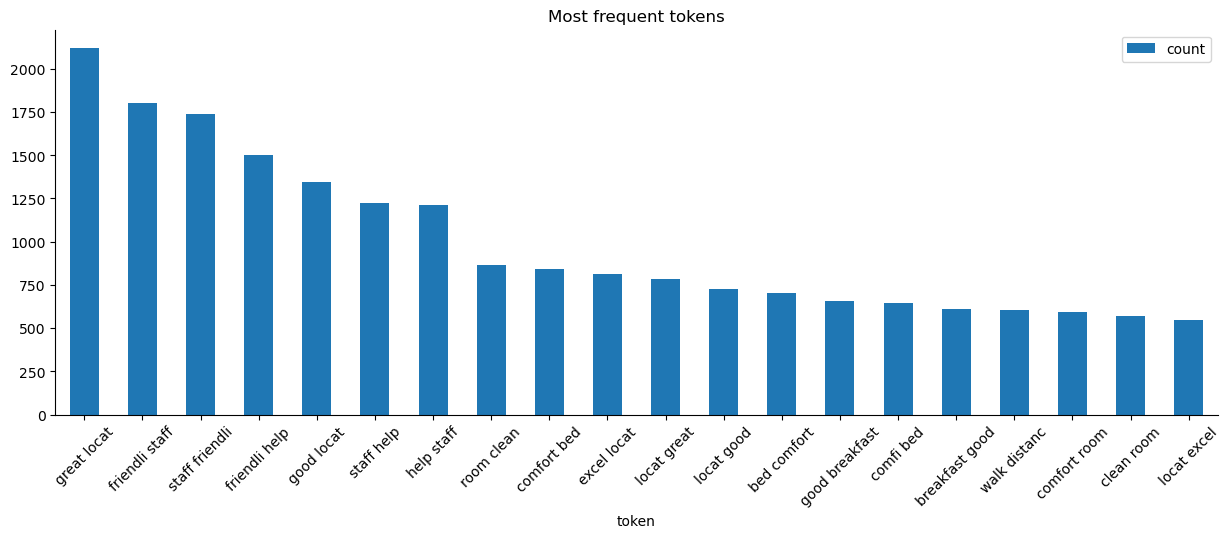

In [252]:
#refit bagofwords for bigrams
bagofwords_posi_bigrams_tf = CountVectorizer(tokenizer=my_tokenizer, ngram_range=(2,2), min_df=10, max_df=0.8)
bagofwords_posi_bigrams_tf.fit(X_train_posi)
X_train_posi_transform_bi = bagofwords_posi_bigrams_tf.transform(X_train_posi)
X_test_posi_transform_bi = bagofwords_posi_bigrams_tf.transform(X_test_posi)
#plot bigrams
words = bagofwords_posi_bigrams_tf.get_feature_names()
word_counts = X_train_posi_transform_bi.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

Let's do the same for the negative reviews, creating a separate vectorized array.

In [253]:
# Instantiate TF model. Note that tokens are being stemmed but NOT lemmatized at this stage.
bagofwords_negi_tf = CountVectorizer(tokenizer=my_tokenizer, min_df=10, max_df=0.8)

In [254]:
X_train_negi = X_train['Negative_Review']
X_test_negi = X_test['Negative_Review']

In [255]:
bagofwords_negi_tf.fit(X_train_negi)
X_train_negi_transform = bagofwords_negi_tf.transform(X_train_negi)
X_test_negi_transform = bagofwords_negi_tf.transform(X_test_negi)

In [256]:
X_train_negi_transform.shape

(36065, 2212)

As can be seen, the word vectorisation matrix is 36065 rows long(as for the positive equivalent), and 2227 columns wide (the number of unique tokens from the positive reviews). This suggests that there is a wider range of vocabulary used in the negative reviews. Let's visualise the tokens to see the most frequent negative tokens.

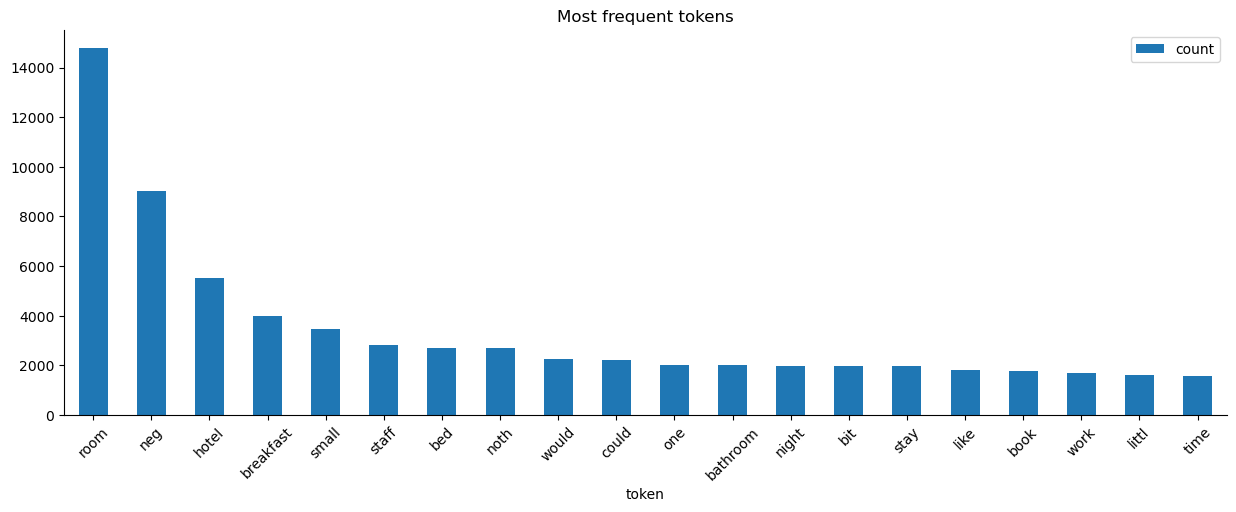

In [257]:
words = bagofwords_negi_tf.get_feature_names()
word_counts = X_train_negi_transform.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

Negative reviews seem to be foused around the room, and breakfast. Some of the words seem to be rather generic. The TF-IDF bagof wordws vectorizer should account for the frequency in the wider context of the corpus, and identify more relevant words. Let's repeat the negative bigrams but using TFIDF.

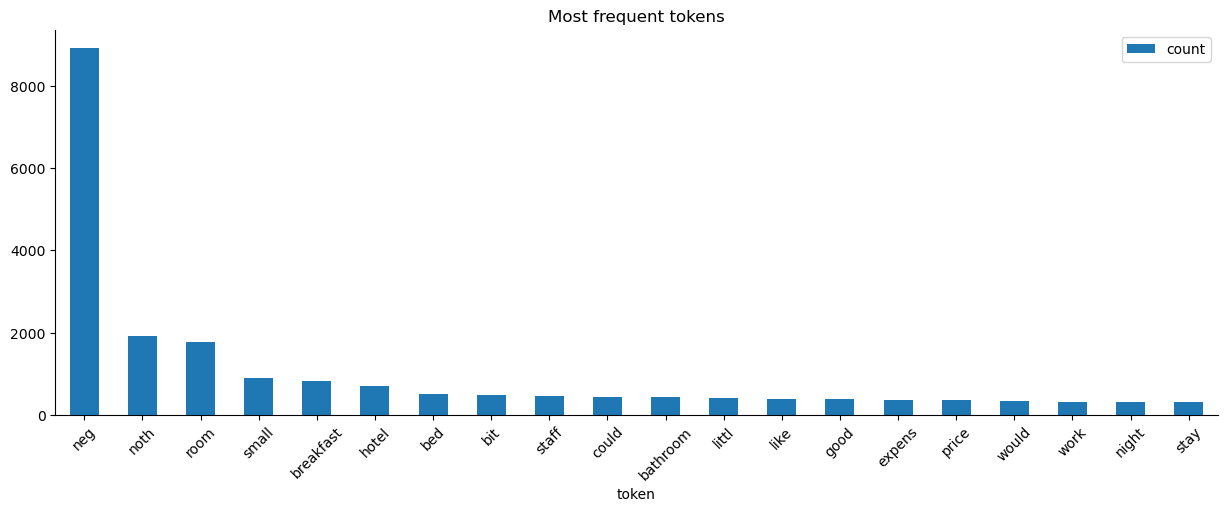

In [258]:
# Instantiate TF model. Note that tokens are being stemmed but NOT lemmatized at this stage.
# instantiate, fit and transform.

bagofwords_negi_tfidf = TfidfVectorizer(tokenizer=my_tokenizer, )
bagofwords_negi_tfidf.fit(X_train_negi)
X_train_negi_transform_tfidf = bagofwords_negi_tfidf.transform(X_train_negi)
X_test_negi_transform_tfidf = bagofwords_negi_tfidf.transform(X_test_negi)

#plot
words = bagofwords_negi_tfidf.get_feature_names()
word_counts = X_train_negi_transform_tfidf.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)


Interestingly TFIDF seems to give us a less clear picture of key words. Going forward, TF is to be used, unless the model accuracy is very poor further down the line.

Let's plot the most common bigrams using TF vectorisation.

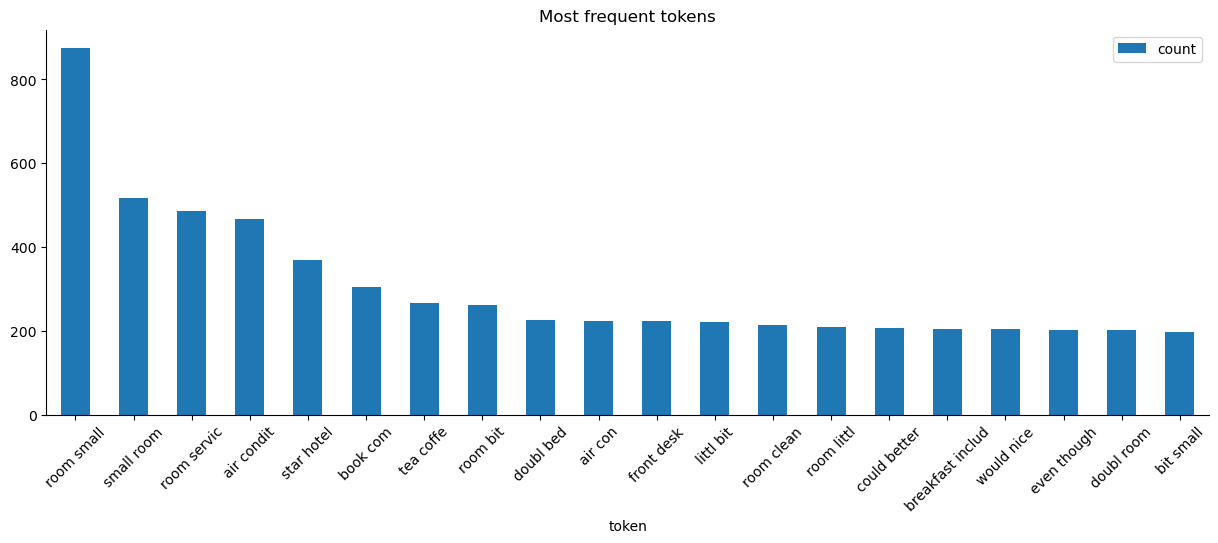

In [259]:
#refit bagofwords for bigrams
bagofwords_negi_bigrams_tf = CountVectorizer(tokenizer=my_tokenizer, ngram_range=(2,2), min_df=10, max_df=0.8)
bagofwords_negi_bigrams_tf.fit(X_train_negi)
X_train_negi_transform_bi = bagofwords_negi_bigrams_tf.transform(X_train_negi)
X_test_negi_transform_bi = bagofwords_negi_bigrams_tf.transform(X_test_negi)
#plot bigrams
words = bagofwords_negi_bigrams_tf.get_feature_names()
word_counts = X_train_negi_transform_bi.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

There seem to be a few recurring themes here, with the small room and the air conditioning seeming to be problem areas. 

#### Creating positive and negative dataframes for the training data

The vectorised bag of words have now been created for both the positive and negative training and test datasets. It is now a task of combining these matrices, so that we ultimately have a single dataframe for all training data (X and y features) and a second dataframe for all of the test data. Before combining positive and negative dataframes, a '_posi' and '_negi' suffix needs to be added to the dataframe headers, to ensure that when combining positive and negative dataframes later on, the model will be able to distinguish between the same words found in both positive and negative reviews.

In [260]:
#converting the postive train vectorised matrix to a dataframe.
df_posi_train = pd.DataFrame(data=X_train_posi_transform.toarray(), columns = bagofwords_posi_tf.get_feature_names())

In [261]:
df_posi_train = df_posi_train.add_suffix('_posi')
df_posi_train

,abbey_posi,abl_posi,absolut_posi,abund_posi,ac_posi,accept_posi,access_posi,accessori_posi,accommod_posi,accomod_posi,...,x_posi,xx_posi,yard_posi,ye_posi,year_posi,yet_posi,yoghurt_posi,young_posi,yummi_posi,zone_posi
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36061,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [262]:
#converting the negative train vectorised matrix to a dataframe.
df_negi_train = pd.DataFrame(data=X_train_negi_transform.toarray(), columns = bagofwords_negi_tf.get_feature_names())

/Users/henryparemain/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [263]:
df_negi_train = df_negi_train.add_suffix('_negi')
df_negi_train

,abit_negi,abl_negi,abrupt_negi,absenc_negi,absolut_negi,abysm_negi,ac_negi,accept_negi,access_negi,accommod_negi,...,x_negi,yard_negi,ye_negi,year_negi,yell_negi,yellow_negi,yet_negi,young_negi,zero_negi,zone_negi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Creating positive and negative dataframes for the test data

In [264]:
#converting the positive test vectorised matrix to a dataframe.
df_posi_test = pd.DataFrame(data=X_test_posi_transform.toarray(), columns = bagofwords_posi_tf.get_feature_names())

/Users/henryparemain/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [265]:
df_posi_test = df_posi_test.add_suffix('_posi')
df_posi_test

,abbey_posi,abl_posi,absolut_posi,abund_posi,ac_posi,accept_posi,access_posi,accessori_posi,accommod_posi,accomod_posi,...,x_posi,xx_posi,yard_posi,ye_posi,year_posi,yet_posi,yoghurt_posi,young_posi,yummi_posi,zone_posi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
#converting the negative test vectorised matrix to a dataframe.
df_negi_test = pd.DataFrame(data=X_test_negi_transform.toarray(), columns = bagofwords_negi_tf.get_feature_names())

/Users/henryparemain/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [267]:
df_negi_test = df_negi_test.add_suffix('_negi')
df_negi_test

,abit_negi,abl_negi,abrupt_negi,absenc_negi,absolut_negi,abysm_negi,ac_negi,accept_negi,access_negi,accommod_negi,...,x_negi,yard_negi,ye_negi,year_negi,yell_negi,yellow_negi,yet_negi,young_negi,zero_negi,zone_negi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Combining `df_posi_train`, `df_negi_train` and remaining numerical X_train dataframe

In [268]:
#obtain dataframe for all remaining numerical training data
X_train_nums = X_train.drop(columns=['Positive_Review','Negative_Review'])

In [269]:
X_train_nums.shape

(36065, 9)

In [270]:
df_posi_train.shape

(36065, 1791)

In [271]:
df_negi_train.shape

(36065, 2212)

The shapes of all three matrices to be combined all have the same number of rows. This means that we can simply concatenate the 3 dataframes along axis 1 with no issues.

In [272]:
df_pos_neg_train = pd.concat([df_posi_train, df_negi_train], axis=1)

In [273]:
X_train_nums = X_train_nums.reset_index()

In [274]:
df_train_X = pd.concat([X_train_nums, df_pos_neg_train], axis = 1).reset_index().drop(columns=['level_0','index'])

In [275]:
df_train_X.shape

(36065, 4012)

In [276]:
df_train_X.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review,lat,lng,abbey_posi,...,x_negi,yard_negi,ye_negi,year_negi,yell_negi,yellow_negi,yet_negi,young_negi,zero_negi,zone_negi
0,258,8.1,63,1018,76,1,33,51.508420,0.025322,0,...,0,0,0,0,0,0,0,0,0,0
1,1322,8.4,23,6117,7,1,171,51.501400,-0.116009,0,...,0,0,0,0,0,0,0,0,0,0
2,563,8.6,0,4000,43,1,518,45.463822,9.194027,0,...,0,0,0,0,0,0,0,0,0,0
3,116,8.1,16,1395,9,2,214,48.196640,16.386382,0,...,0,0,0,0,0,0,0,0,0,0
4,438,7.4,0,1786,28,2,360,51.496740,-0.206472,0,...,0,0,0,0,0,0,0,0,0,0


The training feature set is now in a single dataframe `df_train_X`, with 36066 rows and 4053 columns. Let's repeat for the test data.

#### Combining `df_posi_test`, `df_negi_test` and remaining numerical X_test dataframe

In [277]:
# put all remaining numerical test data into a dataframe
X_test_nums = X_test.drop(columns=['Positive_Review','Negative_Review'])

In [278]:
X_test_nums.shape

(15457, 9)

In [279]:
df_negi_test.shape

(15457, 2212)

In [280]:
df_posi_test.shape

(15457, 1791)

The row dimensions of the three matrices to be jined all correspond meaning that we can concatenate along axis 1.

In [281]:
df_pos_neg_test = pd.concat([df_posi_test, df_negi_test], axis=1)

In [282]:
X_test_nums = X_test_nums.reset_index()

In [283]:
df_test_X = pd.concat([X_test_nums, df_pos_neg_test], axis = 1).reset_index().drop(columns=['level_0','index'])

In [284]:
df_test_X.shape

(15457, 4012)

In [285]:
df_test_X.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review,lat,lng,abbey_posi,...,x_negi,yard_negi,ye_negi,year_negi,yell_negi,yellow_negi,yet_negi,young_negi,zero_negi,zone_negi
0,212,8.7,0,874,36,7,350,51.492548,-0.178061,0,...,0,0,0,0,0,0,0,0,0,0
1,681,8.9,4,2692,10,4,263,51.516099,-0.118175,0,...,0,0,0,0,0,0,0,0,0,0
2,806,7.8,5,3117,31,1,415,51.510574,-0.150995,0,...,0,0,0,0,0,0,0,0,0,0
3,283,8.7,0,2678,7,14,691,45.484237,9.198858,0,...,0,0,0,0,0,0,0,0,0,0
4,168,8.3,43,1064,6,9,312,52.351381,4.872723,0,...,0,0,0,0,0,0,0,0,0,0


The test data X features are now all stored in a single dataframe `df_test_X`. The final thing to do is to insert the y target variable into the two corresponding dataframes, one for training data and one for test data.

In [286]:
# create dataframe for y training data
df_train_y = pd.DataFrame(y_train)

In [287]:
df_train_y = df_train_y.reset_index().drop(columns='index')

In [288]:
df_train_y.shape

(36065, 1)

In [289]:
# create dataframe for y test data
df_test_y = pd.DataFrame(y_test)

In [290]:
df_test_y = df_test_y.reset_index().drop(columns='index')

In [291]:
df_test_y.shape

(15457, 1)

Let's concatenate the `df_train_X` with `df_train_y`, and do the same with `df_test_X` and `df_test_y`.

In [292]:
df_train = pd.concat([df_train_y,df_train_X], axis=1)

In [293]:
df_train.head()

,Reviewer_Score,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review,lat,lng,...,x_negi,yard_negi,ye_negi,year_negi,yell_negi,yellow_negi,yet_negi,young_negi,zero_negi,zone_negi
0,1,258,8.1,63,1018,76,1,33,51.508420,0.025322,...,0,0,0,0,0,0,0,0,0,0
1,0,1322,8.4,23,6117,7,1,171,51.501400,-0.116009,...,0,0,0,0,0,0,0,0,0,0
2,1,563,8.6,0,4000,43,1,518,45.463822,9.194027,...,0,0,0,0,0,0,0,0,0,0
3,0,116,8.1,16,1395,9,2,214,48.196640,16.386382,...,0,0,0,0,0,0,0,0,0,0
4,1,438,7.4,0,1786,28,2,360,51.496740,-0.206472,...,0,0,0,0,0,0,0,0,0,0


In [294]:
df_train.shape

(36065, 4013)

In [295]:
df_test = pd.concat([df_test_y, df_test_X], axis=1)

In [296]:
df_test.head()

,Reviewer_Score,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review,lat,lng,...,x_negi,yard_negi,ye_negi,year_negi,yell_negi,yellow_negi,yet_negi,young_negi,zero_negi,zone_negi
0,1,212,8.7,0,874,36,7,350,51.492548,-0.178061,...,0,0,0,0,0,0,0,0,0,0
1,1,681,8.9,4,2692,10,4,263,51.516099,-0.118175,...,0,0,0,0,0,0,0,0,0,0
2,1,806,7.8,5,3117,31,1,415,51.510574,-0.150995,...,0,0,0,0,0,0,0,0,0,0
3,0,283,8.7,0,2678,7,14,691,45.484237,9.198858,...,0,0,0,0,0,0,0,0,0,0
4,0,168,8.3,43,1064,6,9,312,52.351381,4.872723,...,0,0,0,0,0,0,0,0,0,0


In [297]:
df_test.shape

(15457, 4013)

The final train and test data can be found in the following:

* `df_train`

* `df_test`

Sense check...

In [298]:
print(df_sample.shape[0])
print(df_train.shape[0] + df_test.shape[0])

51522
51522


The number of rows of the train and test dataframe add up the original sampled dataframe which is good.

The `min_df` parameter ensures that any words that occur in less than the number provided are not included in the bagofwords model. This ensures that very rare words are not included. This is a way of reducing the number of columns with low variance, which would ultimately add unncessary columns. This is because a column (or word) which is very rare will only have one or two reviews with a '1' in the column. Hence, the majority of the column will be 0s, and thus the variance of the column will be small, which is not useful for a predictor variable in a classification problem. 